In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
%matplotlib inline

d:\Praca\Projekty\Machine Learning\Birdcall Identification\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('metadata.csv')
"""
Cell generated by Data Wrangler.
"""
def clean_data(df):
    # Drop column: 'Path'
    df = df.drop(columns=['Path'])
    # Drop column: 'Other_species30'
    df = df.drop(columns=['Other_species30'])
    # Drop column: 'Other_species28'
    df = df.drop(columns=['Other_species28'])
    # Drop column: 'Other_species29'
    df = df.drop(columns=['Other_species29'])
    # Drop column: 'Other_species27'
    df = df.drop(columns=['Other_species27'])
    # Drop column: 'Other_species26'
    df = df.drop(columns=['Other_species26'])
    # Drop column: 'Other_species25'
    df = df.drop(columns=['Other_species25'])
    # Drop column: 'Other_species24'
    df = df.drop(columns=['Other_species24'])
    # Drop column: 'Other_species23'
    df = df.drop(columns=['Other_species23'])
    # Drop column: 'Remarks'
    df = df.drop(columns=['Remarks'])
    # Drop column: 'Spectrogram_full'
    df = df.drop(columns=['Spectrogram_full'])
    # Drop column: 'Spectrogram_large'
    df = df.drop(columns=['Spectrogram_large'])
    # Drop column: 'Spectrogram_med'
    df = df.drop(columns=['Spectrogram_med'])
    # Drop column: 'Spectrogram_small'
    df = df.drop(columns=['Spectrogram_small'])
    # Drop column: 'file.name'
    df = df.drop(columns=['file.name'])
    # Convert Date column to datetime format
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    # Replace all instances of "?" with "" in column: 'Altitude'
    df['Altitude'] = df['Altitude'].replace(to_replace='?', value=np.nan)
    # Replace all instances of "" with "" in column: 'Time'
    df['Time'] = df['Time'].replace(to_replace='?', value=np.nan)
    # Ensure 'Altitude' and are numeric, coerce errors to NaN
    df['Altitude'] = pd.to_numeric(df['Altitude'], errors='coerce')
    # Drop rows with missing data in column: 'Date'
    df = df.dropna(subset=['Date','Altitude'])
    # Drop column: 'Url'
    df = df.drop(columns=['Url'])
    # Drop column: 'License'
    df = df.drop(columns=['License'])
    # Drop column: 'Audio_file'
    df = df.drop(columns=['Audio_file'])
    # Capitalize the first character in column: 'Locality'
    df['Locality'] = df['Locality'].str.title()
    return df

df_clean = clean_data(df.copy())
df = df_clean

df.columns.values

# Convert Length from "minutes:seconds" format to total seconds
def convert_to_seconds(length):
    try:
        minutes, seconds = map(int, length.split(':'))
        return minutes * 60 + seconds
    except ValueError:
        return np.nan  # Handle invalid formats as NaN
    
df['Length_seconds'] = df['Length'].apply(convert_to_seconds)

df['Time'] = df['Time'].astype(str)

def convert_time_to_minutes(time_str):
    try:
        if ':' in time_str:
            hours, minutes = map(int, time_str.split(':'))
            return hours * 60 + minutes
        else:
            return np.nan  # Return NaN if the format is not as expected
    except (ValueError, AttributeError):
        return np.nan

df['Time_minutes'] = df['Time'].apply(convert_time_to_minutes)
df

,Recording_ID,Genus,Specific_epithet,Subspecies,English_name,Recordist,Country,Locality,Latitude,Longitude,...,Other_species16,Other_species17,Other_species18,Other_species19,Other_species20,Other_species21,Other_species22,Species,Length_seconds,Time_minutes
2,508571,Sonus,naturalis,NaN,Soundscape,Nelson Conceição,Portugal,"Santo Estêvão, Tavira, Faro",37.1554,-7.6960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sonus naturalis,128,1020.0
3,448534,Sonus,naturalis,NaN,Soundscape,José Carlos Sires,Spain,"Córdoba, Córdoba, Andalucía",37.9321,-4.9446,...,Cyanistes caeruleus,Lophophanes cristatus,Garrulus glandarius,Sylvia melanocephala,NaN,NaN,NaN,Sonus naturalis,1297,NaN
4,373414,Sonus,naturalis,NaN,Soundscape,Lars Lachmann,Germany,"Frohnau, Berlin, North-Eastern Part",52.6408,13.2956,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sonus naturalis,333,268.0
8,442463,Sonus,naturalis,NaN,Soundscape,José Carlos Sires,Spain,"Córdoba, Córdoba, Andalucía",37.9407,-4.8940,...,Spinus spinus,Certhia brachydactyla,Aegithalos caudatus,NaN,NaN,NaN,NaN,Sonus naturalis,1303,NaN
10,447407,Sonus,naturalis,NaN,Soundscape,José Carlos Sires,Spain,"Córdoba, Córdoba, Andalucía",37.9413,-4.8958,...,Aegithalos caudatus,Columba palumbus,Troglodytes troglodytes,NaN,NaN,NaN,NaN,Sonus naturalis,1305,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2145,518681,Glaucidium,passerinum,NaN,Eurasian Pygmy Owl,Daniele Baroni,Finland,"Nousis, Åbo, Southwest Finland",60.6657,22.2822,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Glaucidium passerinum,256,1380.0
2146,401901,Glaucidium,passerinum,passerinum,Eurasian Pygmy Owl,Jarek Matusiak,Russian Federation,"Gmina Dubeninki, Nesterovsky District, Kalinin...",54.3490,22.6561,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Glaucidium passerinum,31,840.0
2147,201176,Glaucidium,passerinum,passerinum,Eurasian Pygmy Owl,Bram Piot,France,"Haut-Jura, Farges, Ain",46.1716,5.8689,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Glaucidium passerinum,58,1050.0
2148,408254,Glaucidium,passerinum,NaN,Eurasian Pygmy Owl,Miklos Heincz,Hungary,"Velem, Kőszegi, Vas County",47.3411,16.4901,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Glaucidium passerinum,40,510.0


In [3]:
# Aggregate by year and month
df['YearMonth'] = df['Date'].dt.to_period('M')
df_monthly = df.groupby('YearMonth').size().reset_index(name='Call_Count')
df_monthly['YearMonth'] = df_monthly['YearMonth'].dt.to_timestamp()

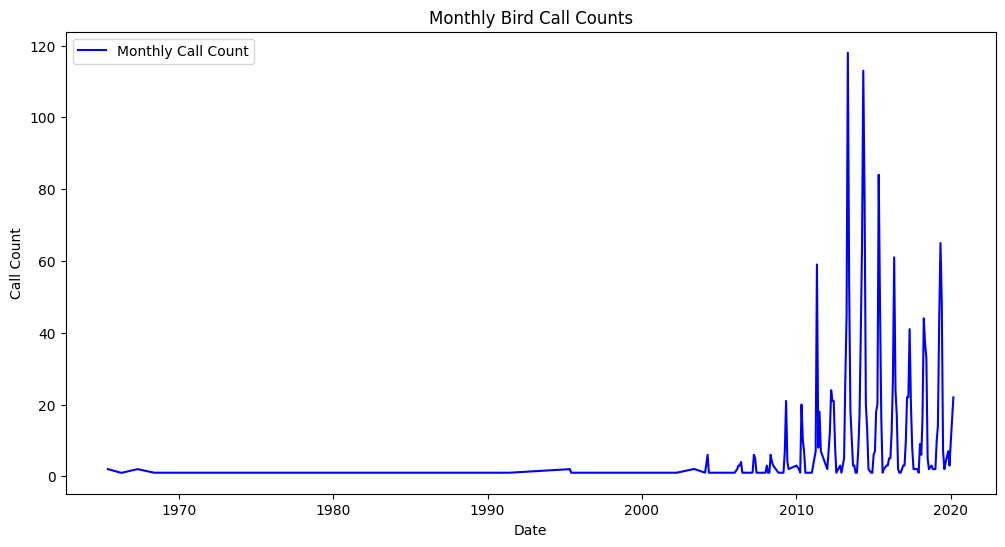

In [4]:
# Plot the aggregated data
plt.figure(figsize=(12, 6))
plt.plot(df_monthly['YearMonth'], df_monthly['Call_Count'], label='Monthly Call Count', color='blue')
plt.title('Monthly Bird Call Counts')
plt.xlabel('Date')
plt.ylabel('Call Count')
plt.legend()
plt.show()

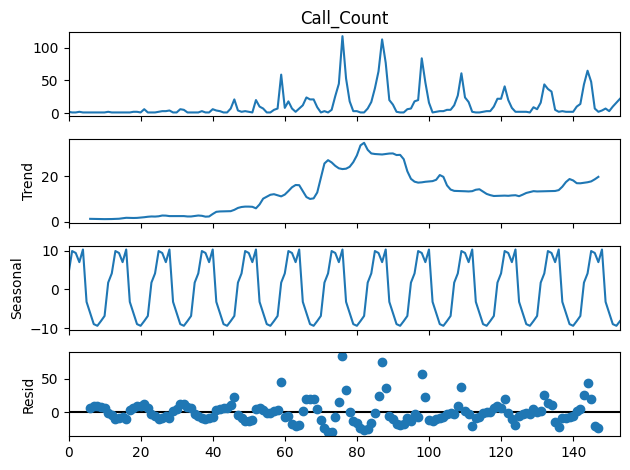

In [6]:
# Decompose the time series
result = seasonal_decompose(df_monthly['Call_Count'], model='additive', period=12)
result.plot()
plt.show()

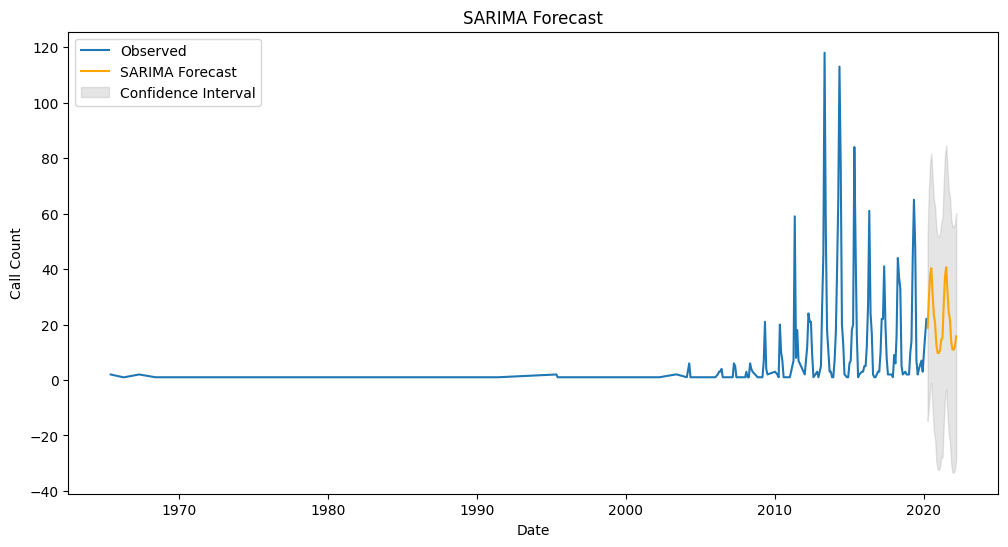

In [22]:
# SARIMA Forecasting
sarima_model = SARIMAX(
    df_monthly['Call_Count'],
    order=(1, 1, 1),  
    seasonal_order=(1, 1, 1, 12), 
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_result = sarima_model.fit(disp=False)


forecast_steps = 24  
sarima_forecast = sarima_result.get_forecast(steps=forecast_steps)
sarima_forecast_ci = sarima_forecast.conf_int()

# Plot SARIMA forecast
plt.figure(figsize=(12, 6))
plt.plot(df_monthly['YearMonth'], df_monthly['Call_Count'], label='Observed')
plt.plot(
    pd.date_range(df_monthly['YearMonth'].iloc[-1], periods=forecast_steps, freq='ME'),
    sarima_forecast.predicted_mean,
    label='SARIMA Forecast',
    color='orange'
)
plt.fill_between(
    pd.date_range(df_monthly['YearMonth'].iloc[-1], periods=forecast_steps, freq='ME'),
    sarima_forecast_ci.iloc[:, 0],
    sarima_forecast_ci.iloc[:, 1],
    color='gray',
    alpha=0.2,
    label='Confidence Interval'
)
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Call Count')
plt.legend()
plt.show()


